![임도형 커멘트](https://github.com/dhrim/keras_example_seminia_2020/raw/master/comment.png)

# 개요

- 원 본 : https://keras.io/examples/generative/wgan_gp/
- 작업 : fashion MNIST를 WGAN-GP로 학습
- 데이터 : fashion MNIST
- 적용 모델 : WGAN-GP


<br>

# 데이터

fashion MNIST


<br>

# WGAN-GP

학습이 잘 되도록 vanila GAN의 로스를 변경한 것.
Wastertein loss를 사용하고, grandient에 패널티를 포함했다.



<br>


# 특이 사항

fashion MNIST는 28x28 크기이다.

2의 배수로 처리하려면 32x32크기로 하는게 편한다.

이를 위해 ZeroPadding2D과 Cropping2D를 사용하였다.

```
Discriminator에서 28x28 입력을 받고서 이를 32x32로
x = layers.ZeroPadding2D((2, 2))(img_input)

Generator에서 32x32로 생성하고 이를 28x28로 
x = layers.Cropping2D((2, 2))(x)
```


<br>

# Model.train_step() 변경

일반적으로 model.fit()을 호출하면 Keras는 내부적으로 model.train_step()을 호출한다.

여기에서는 train_step()을 다시 정의하여 사용하였다.











# 태그
```
#fashion_mnist
#wgan-gp
#save_image_on_epoch
```

# WGAN-GP overriding `Model.train_step`

**Author:** [A_K_Nain](https://twitter.com/A_K_Nain)<br>
**Date created:** 2020/05/9<br>
**Last modified:** 2020/05/9<br>
**Description:** Implementation of Wasserstein GAN with Gradient Penalty.

## Wasserstein GAN (WGAN) with Gradient Penalty (GP)

The original [Wasserstein GAN](https://arxiv.org/abs/1701.07875) leverages
the Wasserstein distance to produce a value function that has better theoretical
properties than the value function used in the original GAN paper. WGAN requires that
the discriminator (aka the critic) lie within the space of 1-Lipschitz functions.
The authors proposed the idea of weight clipping to achieve this constraint. Though
weight clipping works, it can be a problematic way to enforce 1-Lipschitz constraint
and can cause undesirable behavior, e.g. a very deep WGAN discriminator (critic)
often fails to converge.

[WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf) proposed an alternative to weight
clipping to ensure smooth training. Instead of clipping the weights, the authors
proposed a "gradient penalty": adding a loss term that keeps the L2
norm of the discriminator gradients close to 1.


## Setup


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



## Prepare Fashion-MNIST data

We will be using the [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset
in this example to demonstrate the training of WGAN-GP. Each sample in this dataset is a 28x28
grayscale image associated with a label from 10 classes (e.g. Trouser, Pullover, Sneaker, etc.)


In [2]:
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 512

# Size of noise vector
noise_dim = 128

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

# we will reshape each sample to (28, 28, 1) and normalize the pixel values in [-1, 1].
train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
train_images = (train_images - 127.5) / 127.5


4423680/4422102 [==============================] - 0s 0us/step
Number of examples: 60000
Shape of the images in the dataset: (28, 28)


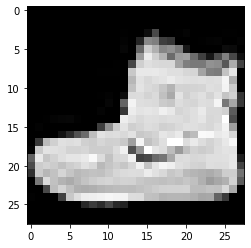

In [9]:
import matplotlib.pyplot as plt

plt.imshow(train_images[0].squeeze(), cmap='gray')
plt.show()

## Create the discriminator (aka critic in the original WGAN)

The samples in the dataset have shape `(28, 28, 1)`. As we will be
using strided convolutions, this can result in a shape with odd dimensions.
For example,
`(28, 28) -> Conv_s2 -> (14, 14) -> Conv_s2 -> (7, 7) -> Conv_s2 ->(3, 3)`.

While doing upsampling in the generator, we won't get the same input shape
as the original images if we aren't careful. To avoid this, we will do
something much simpler. In the discriminator, we will "zero pad" the input
to make the shape `(32, 32, 1)` for each sample, while in the generator we will
crop the final output to match the shape with input shape.


In [3]:

def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)
    # Zero pad the input to make the input images size to (32, 32, 1).
    x = layers.ZeroPadding2D((2, 2))(img_input)
    x = conv_block(
        x,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()


Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 128)       

## Create the generator


In [4]:

def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x, 1, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    # At this point, we have an output which has the same shape as the input, (32, 32, 1).
    # We will use a Cropping2D layer to make it (28, 28, 1).
    x = layers.Cropping2D((2, 2))(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()


Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              524288    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         29

## Create a WGAN-GP model

Now that we have defined our generator and discriminator models, we will
implement the WGAN-GP model. We will override the `train_step` for training.


In [5]:

class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # get the interplated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper.
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add gradient penalty to the discriminator loss
        # 6. Return generator and discriminator losses as a loss dictionary.

        # Train discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate discriminator loss using fake and real logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator now.
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}



## Create a callback that periodically saves generated images


In [6]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = keras.preprocessing.image.array_to_img(img)
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))



## Train the end-to-end model


In [7]:
# Optimizer for both the networks
# learning_rate=0.0002, beta_1=0.5 are recommened
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions to be used for discrimiator
# This should be (fake_loss - real_loss)
# We will add the gradient penalty later to this loss function
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions to be used for generator
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Epochs to train
epochs = 20

# Callbacks
cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

# Get the wgan model
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the wgan model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])


Epoch 1/20
118/118 [==============================] - 70s 594ms/step - d_loss: -7.7284 - g_loss: -16.3324
Epoch 2/20
118/118 [==============================] - 71s 599ms/step - d_loss: -7.2995 - g_loss: -3.7804
Epoch 3/20
118/118 [==============================] - 71s 598ms/step - d_loss: -6.4038 - g_loss: 5.2266
Epoch 4/20
118/118 [==============================] - 71s 598ms/step - d_loss: -5.7124 - g_loss: 10.0293
Epoch 5/20
118/118 [==============================] - 71s 598ms/step - d_loss: -5.2442 - g_loss: 9.7953
Epoch 6/20
118/118 [==============================] - 71s 598ms/step - d_loss: -4.8464 - g_loss: 10.1211
Epoch 7/20
118/118 [==============================] - 71s 598ms/step - d_loss: -4.4917 - g_loss: 10.3924
Epoch 8/20
118/118 [==============================] - 70s 597ms/step - d_loss: -4.1899 - g_loss: 9.3160
Epoch 9/20
118/118 [==============================] - 70s 597ms/step - d_loss: -3.9924 - g_loss: 8.5732
Epoch 10/20
118/118 [==============================] - 71s

Display the last generated images:


In [8]:
from IPython.display import Image, display

display(Image("generated_img_0_19.png"))
display(Image("generated_img_1_19.png"))
display(Image("generated_img_2_19.png"))


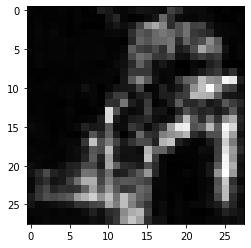

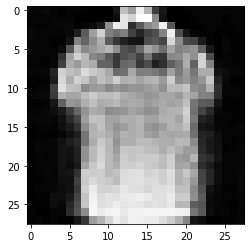

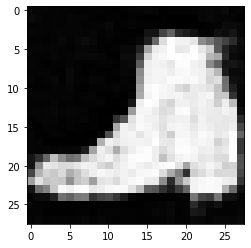

In [13]:
import matplotlib.pyplot as plt
from matplotlib import image


img = image.imread('generated_img_0_19.png')
plt.imshow(img, cmap='gray')
plt.show()

img = image.imread('generated_img_1_19.png')
plt.imshow(img, cmap='gray')
plt.show()


img = image.imread('generated_img_2_19.png')
plt.imshow(img, cmap='gray')
plt.show()
